# Importing libraries

In [16]:
import glob
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Model,Input

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import cv2
from PIL import Image

### Loading and pre-processing the data

In [2]:
train_image = []
train_annotation = []

image_file = glob.glob("/kaggle/input/drone-dataset-uav/drone_dataset_yolo/dataset_txt/*.jpg")

for i in image_file:     #slicing for insufficient memory
    Load_image = Image.open(i).convert('RGB')
    nmpy_img = Load_image.resize((256, 256))
    train_image.append(np.asarray(nmpy_img))
    
    seperate_path = i.split('.')
    seperate_path[1] = '.txt'
    
    with open(seperate_path[0]+seperate_path[1]) as f:
        lines = f.readlines()
        tmp_lst = lines[0].split(' ')
        #label = int(tmp_lst[0])
        startX = float(tmp_lst[1])
        startY = float(tmp_lst[2])
        endX = float(tmp_lst[3])
        endY = float(tmp_lst[4])
        train_annotation.append((startX, startY, endX, endY))

### Displaying sample images

1359


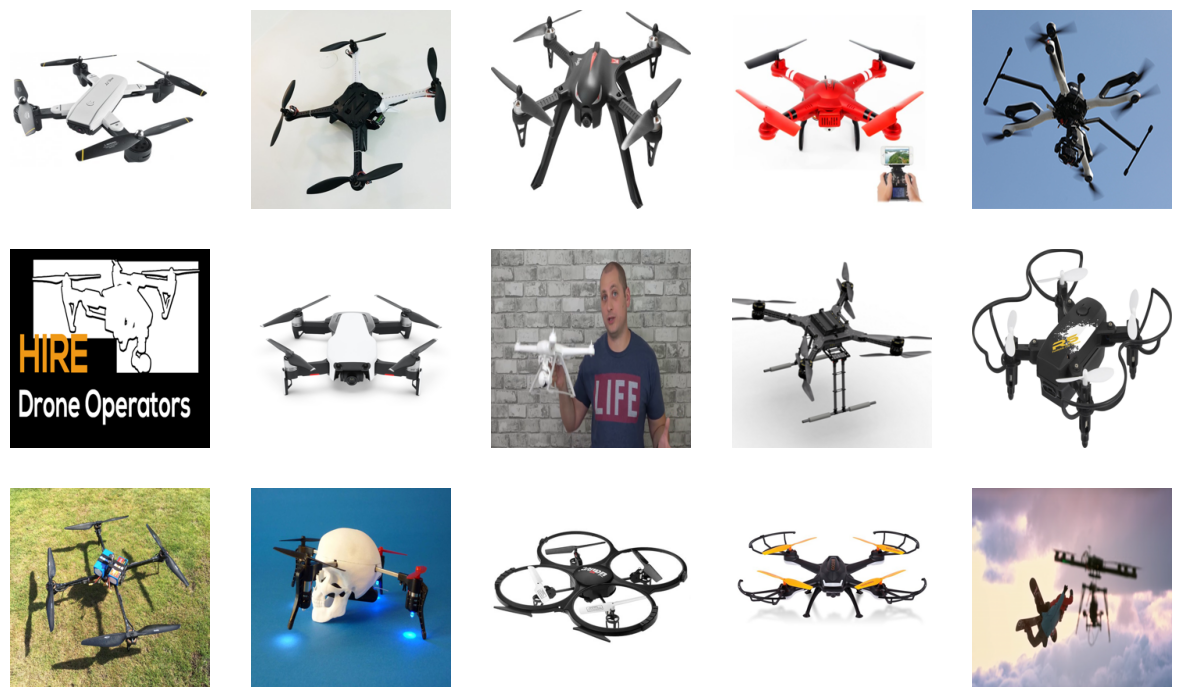

In [3]:
print(len(train_image))

plt.figure(figsize=(15, 15))

for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(train_image[i].astype("uint8"))
    plt.axis("off")

### Splitting the data into training and testing sets

In [4]:
from sklearn.model_selection import train_test_split
data = np.array(train_image, dtype='float32') / 255.0   # memory not sufficient !!
targets = np.array(train_annotation, dtype='float32')

split = train_test_split(data, targets, test_size=0.10, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]

# Printing the shapes of the data and targets arrays

data.shape, targets.shape

((1359, 256, 256, 3), (1359, 4))

## CNN

### VGG16

### Building model

In [5]:
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Model,Input

def build_vggmodel():
    vgg = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3)))

    vgg.trainable = True

    flatten = vgg.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(128, activation="relu")(flatten)
    bboxHead = Dense(64, activation="relu")(bboxHead)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(4, activation="linear")(bboxHead)

    vggmodel = Model(inputs=vgg.input, outputs=bboxHead)
    
    return vggmodel

vggmodel = build_vggmodel()

vggmodel.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

## Compiling and training the model

In [6]:
vggmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])

save_best = tf.keras.callbacks.ModelCheckpoint("VGGModel.h5",monitor='val_loss',save_best_only=True, verbose=1)

historyvgg= vggmodel.fit(
    trainImages,
    trainTargets,
    validation_split=0.2,
    batch_size= 16,
    epochs=50,
    verbose=1,
    callbacks=[save_best]
)

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 3.2976 - accuracy: 0.6074
Epoch 1: val_loss improved from inf to 0.03306, saving model to VGGModel.h5
62/62 [==============================] - 25s 184ms/step - loss: 3.2976 - accuracy: 0.6074 - val_loss: 0.0331 - val_accuracy: 0.6449
Epoch 2/50
61/62 [============================>.] - ETA: 0s - loss: 0.0343 - accuracy: 0.6301
Epoch 2: val_loss did not improve from 0.03306
62/62 [==============================] - 9s 143ms/step - loss: 0.0343 - accuracy: 0.6309 - val_loss: 0.0363 - val_accuracy: 0.6449
Epoch 3/50
61/62 [============================>.] - ETA: 0s - loss: 0.0314 - accuracy: 0.6383
Epoch 3: val_loss improved from 0.03306 to 0.02813, saving model to VGGModel.h5
62/62 [==============================] - 9s 152ms/step - loss: 0.0314 - accuracy: 0.6380 - val_loss: 0.0281 - val_accuracy: 0.6612
Epoch 4/50
61/62 [============================>.] - ETA: 0s - loss: 0.0290 - accuracy: 0.6609
Epoch 4: val_loss improved 

### Predictions on test images

In [7]:
vggmodel = tf.keras.models.load_model('VGGModel.h5')

vggmodel.predict(testImages[:10], verbose=1)

1/1 [==============================] - 1s 1s/step


array([[0.5200759 , 0.4976328 , 0.9404158 , 0.36528575],
       [0.3811683 , 0.48563054, 0.97291684, 0.49640042],
       [0.45323738, 0.48888215, 0.7912184 , 0.7381688 ],
       [0.46453553, 0.47124514, 0.7339408 , 0.57145685],
       [0.53206336, 0.549848  , 0.8886368 , 0.59935147],
       [0.5054245 , 0.48839763, 0.8876575 , 0.43267798],
       [0.4736942 , 0.6477866 , 0.47250888, 0.4364094 ],
       [0.5263924 , 0.41661468, 0.63046354, 0.73305565],
       [0.46575496, 0.3957042 , 0.76226234, 0.49726778],
       [0.4677264 , 0.43245926, 0.68009347, 0.5317973 ]], dtype=float32)

### Performance

#### Acccuracy vs No. of epochs graph

Final Training Accuracy: 0.8762781023979187
Final Validation Accuracy: 0.7346938848495483


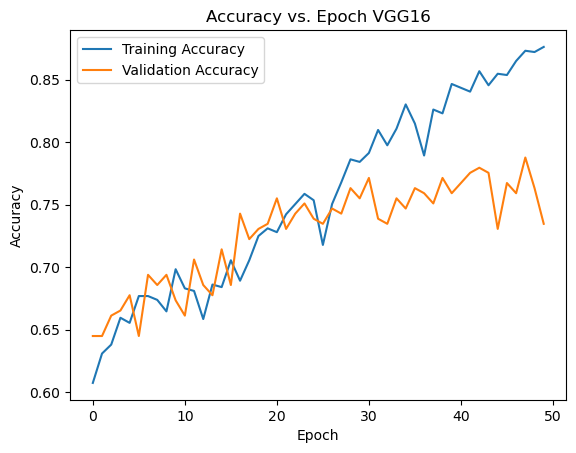

In [8]:
print('Final Training Accuracy:', historyvgg.history['accuracy'][-1])
print('Final Validation Accuracy:', historyvgg.history['val_accuracy'][-1])

plt.plot(historyvgg.history['accuracy'], label='Training Accuracy')
plt.plot(historyvgg.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch VGG16')
plt.legend()
plt.show()

#### Loss vs No. of epochs graph

Final Training Loss: 0.0030222656205296516
Final Validation Loss: 0.019872745499014854


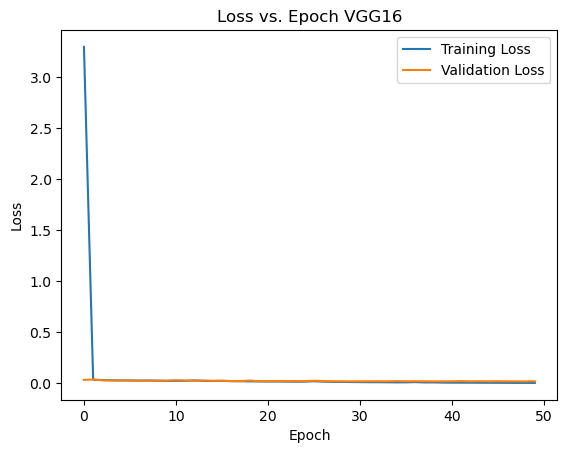

In [9]:
print('Final Training Loss:', historyvgg.history['loss'][-1])
print('Final Validation Loss:', historyvgg.history['val_loss'][-1])

plt.plot(historyvgg.history['loss'], label='Training Loss')
plt.plot(historyvgg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch VGG16')
plt.legend()
plt.show()

### Evaluating on test images

In [10]:
loss, accuracy = vggmodel.evaluate(testImages, testTargets, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

5/5 [==============================] - 5s 329ms/step - loss: 0.0175 - accuracy: 0.8088
Test Loss: 0.01747192069888115
Test Accuracy: 0.8088235259056091


## YOLOv8

In [17]:
!pip install -q ultralytics

## Setup dataset

In [18]:
import shutil
from tqdm import tqdm

DATA_DIR = "/kaggle/input/drone-dataset-uav/drone_dataset_yolo/dataset_txt"

images = []
labels = []
image_paths = glob.glob(os.path.join(DATA_DIR, "*.jpg"))

for image_path in tqdm(image_paths):     #slicing for insufficient memory
    images.append(image_path)
    label_path = image_path.split('.')[0] + '.txt'
    labels.append(label_path)


100%|██████████| 1359/1359 [00:00<00:00, 717801.18it/s]


In [19]:
from sklearn.model_selection import train_test_split
split = train_test_split(images, labels, test_size=0.10, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]

In [20]:
TRAIN_IMAGE_DIR = 'train/images'
TRAIN_LABEL_DIR = 'train/labels'
VAL_IMAGE_DIR = 'valid/images'
VAL_LABEL_DIR = 'valid/labels'

os.makedirs(TRAIN_IMAGE_DIR, exist_ok=True)
os.makedirs(TRAIN_LABEL_DIR, exist_ok=True)

os.makedirs(VAL_IMAGE_DIR, exist_ok=True)
os.makedirs(VAL_LABEL_DIR, exist_ok=True)

for path in tqdm(trainImages):
    shutil.copyfile(path, os.path.join(TRAIN_IMAGE_DIR, os.path.basename(path)))

for path in tqdm(testImages):
    shutil.copyfile(path, os.path.join(VAL_IMAGE_DIR, os.path.basename(path)))

for path in tqdm(trainTargets):
    shutil.copyfile(path, os.path.join(TRAIN_LABEL_DIR, os.path.basename(path)))

for path in tqdm(testTargets):
    shutil.copyfile(path, os.path.join(VAL_LABEL_DIR, os.path.basename(path)))

100%|██████████| 136/136 [00:00<00:00, 318.62it/s]


In [21]:
%%writefile drone.yaml

path: /kaggle/working
train: train/images
val: valid/images

nc: 1

# Classes
names: ['drone']

Overwriting drone.yaml


In [16]:
# %load_ext tensorboard
# %tensorboard --logdir ultralytics/runs

In [24]:
# Disable wandb
import os
os.environ['WANDB_DISABLED'] = 'true'

In [25]:
from ultralytics import YOLO
# Load a model
# model = YOLO("yolov8s.yaml")  # build a new model from scratch
model = YOLO("yolov8s.pt")  # load a pretrained model (recommended for training)

In [ ]:
# Use the model
results = model.train(
   data='drone.yaml',
   imgsz=224,
   epochs=30,
   batch=2,
)  # train the model

New https://pypi.org/project/ultralytics/8.3.113 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.145 🚀 Python-3.7.12 torch-1.13.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=drone.yaml, epochs=30, patience=50, batch=2, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False,

## Visualize performance

In [ ]:
import math
import random

# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=None, num_cols=1):
    """
    Function accepts a list of images and plots
    """
    image_names = sorted(glob.glob(os.path.join(result_dir, '*.jpg')))
    
    if num_samples is not None:
        image_names = random.sample(image_names, num_samples)
        
    num_images = len(image_names)
    num_rows = int(math.ceil(num_images / num_cols))
    plt.figure(figsize=(12 * num_cols, 6 * num_rows))
    
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
visualize('runs/detect/yolov8s_v8_50e', num_cols=1)

## Inference on Validation Images

In [ ]:
# results = model("/kaggle/input/drone-dataset-uav/drone_dataset_yolo/dataset_txt/0014.jpg", conf=0.5, agnostic_nms=True, iou=0.5)  # predict on an image
results = model("valid/images", conf=0.5, agnostic_nms=True, iou=0.5, save=True)
res_plotted = results[0].plot()
plt.imshow(res_plotted)
plt.show()

In [ ]:
res_plotted = results[1].plot()
plt.imshow(res_plotted)
plt.show()

In [ ]:
indices = list(range(len(results)))
random_indices = random.sample(indices, 10)
num_cols = 2
num_rows = 5

plt.figure(figsize=(12 * num_cols, 6 * num_rows))
    
for i, idx in enumerate(random_indices):
    image = results[i].plot()
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
success = model.export(format="onnx")  # export the model to ONNX format
success